In [103]:
import torch 
from collections.abc import Iterable
from datasets import load_dataset, list_datasets, concatenate_datasets

# Model and tokenizer from 🤗 Transformers
from transformers import AutoModelForSequenceClassification, \
    BertForSequenceClassification, BertTokenizerFast, AutoModel, AutoTokenizer

# Code you will write for this assignment
from train_model import init_model, preprocess_dataset, init_trainer, preprocess_dataset_hatexplain
from test_model import init_tester

import numpy as np
import pickle

import seaborn as sn
import matplotlib.pyplot as plt

In [104]:
hate_speech = load_dataset("hate_speech_offensive")

Found cached dataset hate_speech_offensive (/Users/junzeli/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5)


  0%|          | 0/1 [00:00<?, ?it/s]

In [105]:
hate_speech['train']['tweet'][3]

'!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny'

In [106]:
hatexplain = load_dataset("hatexplain")

Found cached dataset hatexplain (/Users/junzeli/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249)


  0%|          | 0/3 [00:00<?, ?it/s]

In [107]:
hatexplain['train']['annotators'][0]

{'label': [0, 2, 2],
 'annotator_id': [203, 204, 233],
 'target': [['Hindu', 'Islam'],
  ['Hindu', 'Islam'],
  ['Hindu', 'Islam', 'Other']]}

In [108]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [109]:
labels = 'original'

hate_speech["train"] = preprocess_dataset(hate_speech["train"], tokenizer, labels)
hatexplain["train"] = preprocess_dataset_hatexplain(hatexplain["train"], tokenizer, labels)
hatexplain["validation"] = preprocess_dataset_hatexplain(hatexplain["validation"], tokenizer, labels)
hatexplain["test"] = preprocess_dataset_hatexplain(hatexplain["test"], tokenizer, labels)

Loading cached processed dataset at /Users/junzeli/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5/cache-bbe824bcb2403eb5.arrow
Loading cached processed dataset at /Users/junzeli/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5/cache-0110407a481ff540.arrow
Loading cached processed dataset at /Users/junzeli/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5/cache-1311d9b2a263b60a.arrow
Loading cached processed dataset at /Users/junzeli/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249/cache-7b8775d38c6a3de0.arrow
Loading cached processed dataset at /Users/junzeli/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249/

In [110]:
bert_dataset = concatenate_datasets([hatexplain['train'], hatexplain['validation'], hatexplain['test'], hate_speech['train']])
remove_cols = [col for col in bert_dataset.column_names if col not in ['demo_props', 'labels', 'input_ids', 'token_type_ids', 'attention_mask',]]

bert_dataset = bert_dataset.remove_columns(remove_cols)
bert_dataset

Dataset({
    features: ['demo_props', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 44012
})

In [111]:
split = bert_dataset.train_test_split(.2, seed=3463)
split_2 = split["train"].train_test_split(.125, seed=3463)
split["train"] = split_2["train"]
split["val"] = split_2["test"]

Loading cached split indices for dataset at /Users/junzeli/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249/cache-cd87080979627ed1.arrow and /Users/junzeli/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249/cache-10afcdcde5f08c97.arrow
Loading cached split indices for dataset at /Users/junzeli/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249/cache-2202b863a7262900.arrow and /Users/junzeli/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249/cache-c7fd0ed1ea0cf090.arrow


In [112]:
split

DatasetDict({
    train: Dataset({
        features: ['demo_props', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 30807
    })
    test: Dataset({
        features: ['demo_props', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8803
    })
    val: Dataset({
        features: ['demo_props', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4402
    })
})

In [113]:
def read_result(file):
    with open(file, 'rb') as f:
        object = pickle.load(f)
    return object

# Base model

In [114]:
obj = read_result('test_results.p')

In [115]:
true_labels = np.array(split['test']['labels'])
len(true_labels)

8803

In [116]:
pred_labels = obj[0].argmax(axis=1)
len(pred_labels)

8803

In [117]:
print(f'acc: {sum(true_labels == pred_labels)/len(pred_labels)}')

acc: 0.7508803816880609


In [118]:
np.set_printoptions(suppress=True)

cm = np.zeros((3,3))
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        cm[i][j] = int(sum((true_labels == i) & (pred_labels == j)))
cm

array([[ 843.,  227.,  368.],
       [ 122., 4700.,  613.],
       [ 163.,  700., 1067.]])

Text(50.722222222222214, 0.5, 'true')

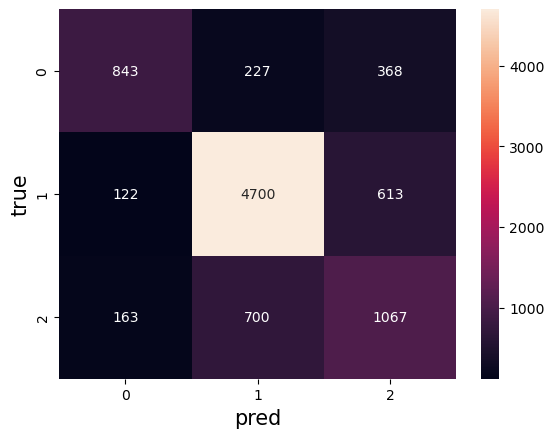

In [119]:
sn.heatmap(cm, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

In [120]:
demo_arr = np.array(split['test']['demo_props'])
demo_l = []

for d in demo_arr:
    if any(d>0.6):
        demo_l.append(np.argmax(d))
    else:
        demo_l.append(-1)
demos = np.array(demo_l)
len(demos)

8803

In [121]:
np.set_printoptions(suppress=True)

cm_aa, cm_his, cm_as, cm_wh = np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3))

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        cm_aa[i][j] = int(sum((true_labels == i) & (pred_labels == j) & (demos == 0)))
        cm_his[i][j] = int(sum((true_labels == i) & (pred_labels == j) & (demos == 1)))
        cm_as[i][j] = int(sum((true_labels == i) & (pred_labels == j) & (demos == 2)))
        cm_wh[i][j] = int(sum((true_labels == i) & (pred_labels == j) & (demos == 3)))

Text(50.722222222222214, 0.5, 'true')

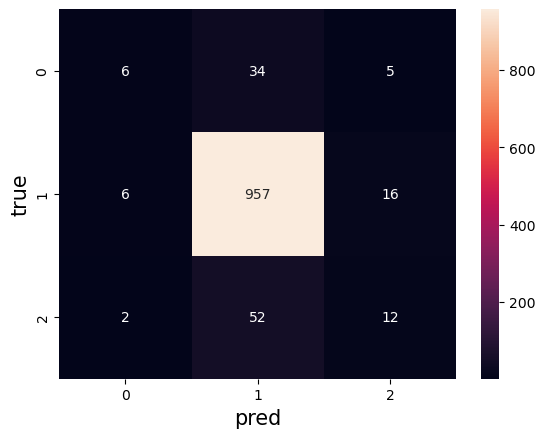

In [122]:
sn.heatmap(cm_aa, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

Text(50.722222222222214, 0.5, 'true')

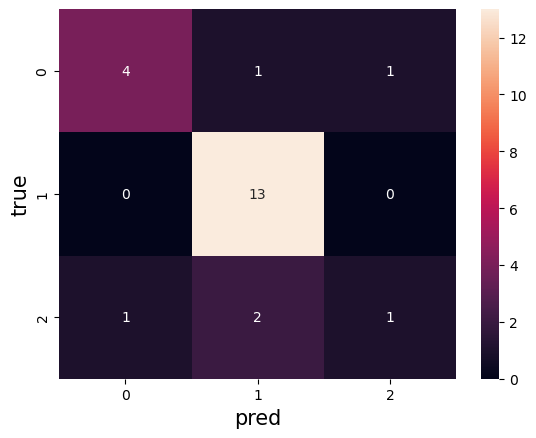

In [123]:
sn.heatmap(cm_his, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

Text(50.722222222222214, 0.5, 'true')

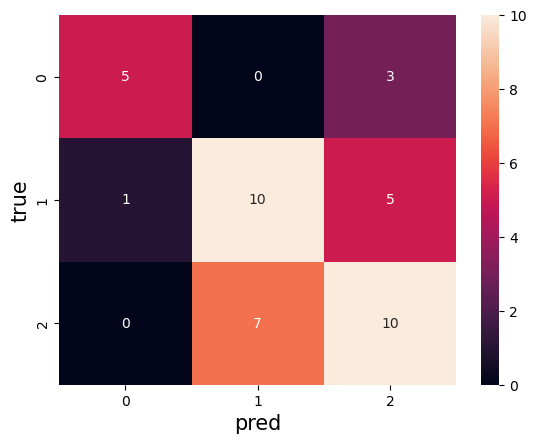

In [124]:
sn.heatmap(cm_as, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

Text(50.722222222222214, 0.5, 'true')

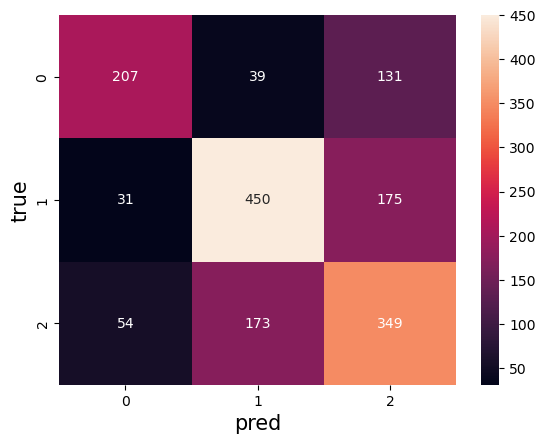

In [125]:
sn.heatmap(cm_wh, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

# Bebiased model

In [126]:
obj = read_result('test_results_debias.p')

In [127]:
true_labels = np.array(split['test']['labels'])
len(true_labels)

8803

In [128]:
pred_labels = obj[0].argmax(axis=1)
len(pred_labels)

8803

In [129]:
print(f'acc: {sum(true_labels == pred_labels)/len(pred_labels)}')

acc: 0.8114279222992162


In [130]:
np.set_printoptions(suppress=True)

cm = np.zeros((3,3))
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        cm[i][j] = int(sum((true_labels == i) & (pred_labels == j)))
cm

array([[1073.,  256.,  109.],
       [ 219., 5012.,  204.],
       [ 302.,  570., 1058.]])

Text(50.722222222222214, 0.5, 'true')

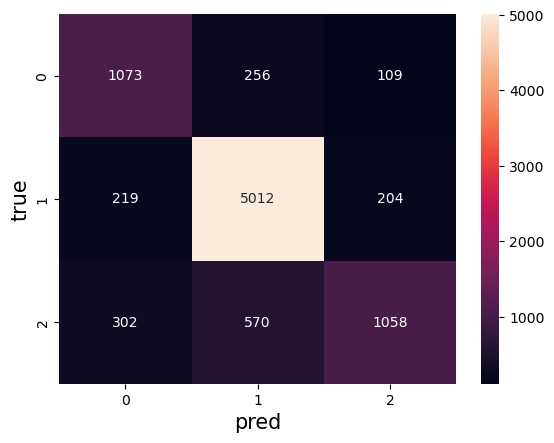

In [131]:
sn.heatmap(cm, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

In [132]:
demo_arr = np.array(split['test']['demo_props'])
demo_l = []

for d in demo_arr:
    if any(d>0.6):
        demo_l.append(np.argmax(d))
    else:
        demo_l.append(-1)
demos = np.array(demo_l)
len(demos)

8803

In [133]:
np.set_printoptions(suppress=True)

cm_aa, cm_his, cm_as, cm_wh = np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3))

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        cm_aa[i][j] = int(sum((true_labels == i) & (pred_labels == j) & (demos == 0)))
        cm_his[i][j] = int(sum((true_labels == i) & (pred_labels == j) & (demos == 1)))
        cm_as[i][j] = int(sum((true_labels == i) & (pred_labels == j) & (demos == 2)))
        cm_wh[i][j] = int(sum((true_labels == i) & (pred_labels == j) & (demos == 3)))

Text(50.722222222222214, 0.5, 'true')

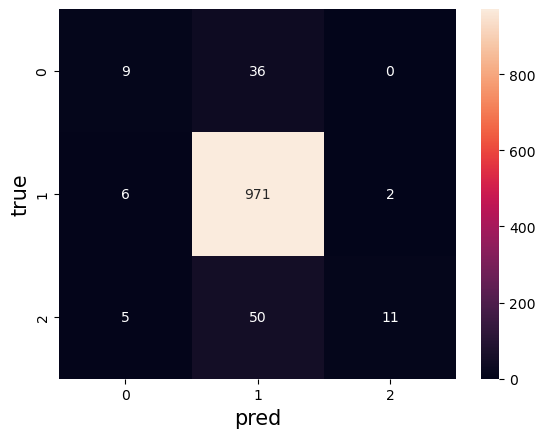

In [134]:
sn.heatmap(cm_aa, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

Text(50.722222222222214, 0.5, 'true')

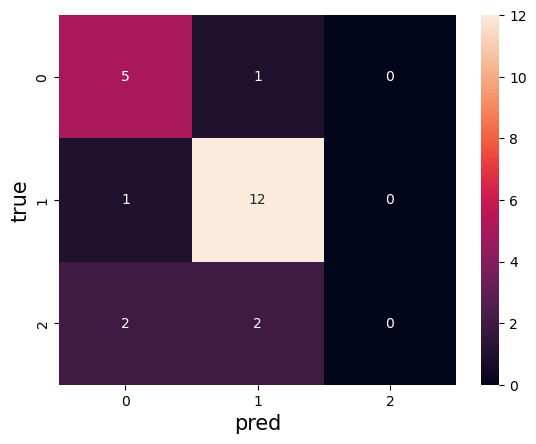

In [135]:
sn.heatmap(cm_his, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

Text(50.722222222222214, 0.5, 'true')

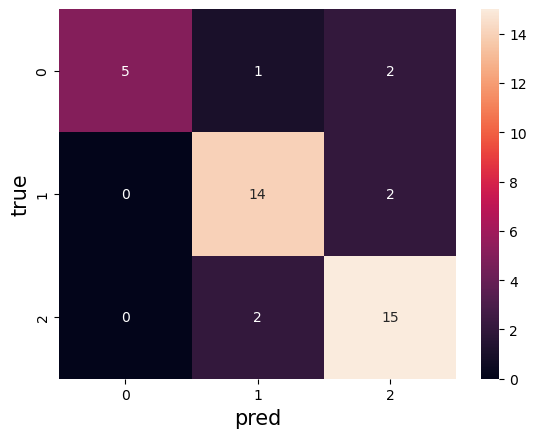

In [136]:
sn.heatmap(cm_as, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

Text(50.722222222222214, 0.5, 'true')

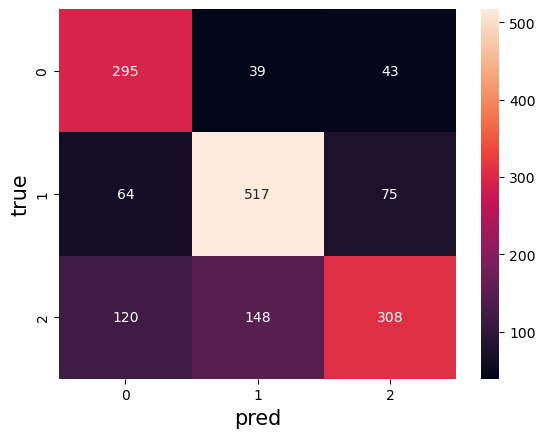

In [137]:
sn.heatmap(cm_wh, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15